In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import ast
%config InlineBackend.figure_format = 'retina' 
from scipy.spatial import cKDTree
from geopy.distance import geodesic
# ignore warnings
import warnings
warnings.filterwarnings('ignore')


/var/folders/qr/0t0s0b6j05d91gr0q4c86jsm0000gn/T/ipykernel_31919/2401342367.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [7]:
blue_color = "#1a80bb"
orange_color = "#ea801c"

## Read data

### HW

In [2]:
hw_us = pd.read_csv("HydroWASTE_v10_US.csv")
gdf_hw_us = gpd.GeoDataFrame(
    hw_us, geometry=gpd.points_from_xy(hw_us.LON_WWTP, hw_us.LAT_WWTP)
)
gdf_hw_us.crs = {"init": "epsg:4326"}
gdf_hw_us.reset_index(drop=True, inplace=True)

In [3]:
us_boundary_path = "US_State_Boundaries"
us_boundary = gpd.read_file(us_boundary_path)
print(us_boundary.crs)
gdf_hw_us = gdf_hw_us.to_crs(us_boundary.crs)
gdf_hw_us = gpd.sjoin(gdf_hw_us, us_boundary, how="inner", op="within")
df_hw_us = gdf_hw_us.loc[:, ["WWTP_NAME", "LAT_WWTP", "LON_WWTP", "NAME"]]
df_hw_us.columns = ["hw_WWTP_NAME", "hw_lat", "hw_lon", "state"]
df_hw_us.head()

EPSG:4326


,hw_WWTP_NAME,hw_lat,hw_lon,state
0,AKRON LAGOON,32.886,-87.740,Alabama
1,ALABASTER WWTP,33.253,-86.815,Alabama
2,ALEXANDER CITY SUGAR CREEK WWTP,32.901,-85.951,Alabama
3,ALEXANDER CITY COLEY CREEK WWTP,32.930,-85.882,Alabama
4,ALTOONA LAGOON,34.038,-86.332,Alabama


In [4]:
print("Number of WWTPs in the US: ", len(df_hw_us))

Number of WWTPs in the US:  14748


### EPA

In [5]:
df_epa = gpd.read_file("../FRS_Wastewater/CWA_summaries_060314.gdb")
df_epa = df_epa.to_crs(epsg=4326)
df_epa.head()  # 5mins to load

,SOURCE_ID,EPA_SYSTEM,REGISTRY_ID,STATUTE,CWP_NAME,CWP_STREET,CWP_CITY,CWP_STATE,CWP_STATE_DISTRICT,CWP_ZIP,...,CWP_COMPLIANCE_TRACKING,FAC_TRI_REPORTER,CWP_CURRENT_VIOL13,CWP_13QTRS_COMPL_STATUS,SIC_CODES,NAICS_CODES,CASE_IDS,STATE_WATER_BODY,STATE_WATER_BODY_NAME,geometry
0,FLR10GF10,ICP,110035653762,CWA,DOWNEY CHRISTIAN SCHOOL MODULA,10201 E COLONIAL DR,ORLANDO,FL,None,32817,...,Off,None,None,__________UU_,None,None,None,None,None,POINT (-81.24056 28.56689)
1,FLR10GF16,ICP,110033168907,CWA,BANANA RIVER SHORELINE STABILI,BANANA RIVER SHORELINE,PATRICK AIR FORCE BASE,FL,None,32925,...,Off,None,None,________UU___,None,None,None,None,None,POINT (-80.60761 28.26509)
2,FLR10JI67,ICP,110041269720,CWA,SANDERS MEMORIAL ELEMENTARY SC,UNKNOWN,LAND O LAKES,FL,None,346383614,...,On,None,None,_____________,None,None,None,None,None,POINT (-82.46347 28.23283)
3,FLR10J788,ICP,110008975243,CWA,ALL SAINTS CATHOLIC ELEMENTARY,1759 INDIAN CREEK PARKWAY,JUPITER,FL,None,33458,...,Off,None,None,_____U_______,None,None,None,None,None,POINT (-80.12671 26.91152)
4,FLR10J793,ICP,110008975289,CWA,WOODRIDGE OAKS,6700 LOCKWOOD RIDGE ROAD,SARASOTA,FL,None,34243,...,Off,None,None,_____U_______,None,None,None,None,None,POINT (-82.50639 27.42083)


In [6]:
gpd_epa = df_epa.loc[:, ["CWP_NAME", "CWP_STATE", "geometry"]]
epa_WWTP = gpd_epa[gpd_epa["CWP_NAME"].str.contains("WWTP|WWTF|STP|WQCF|WRP|WWRF")]
epa_WWTP.drop_duplicates(inplace=True)
epa_WWTP.reset_index(drop=True, inplace=True)
epa_WWTP.loc[:, "epa_lon"] = epa_WWTP.geometry.x
epa_WWTP.loc[:, "epa_lat"] = epa_WWTP.geometry.y
epa_WWTP.shape

(14327, 5)

## world map plot

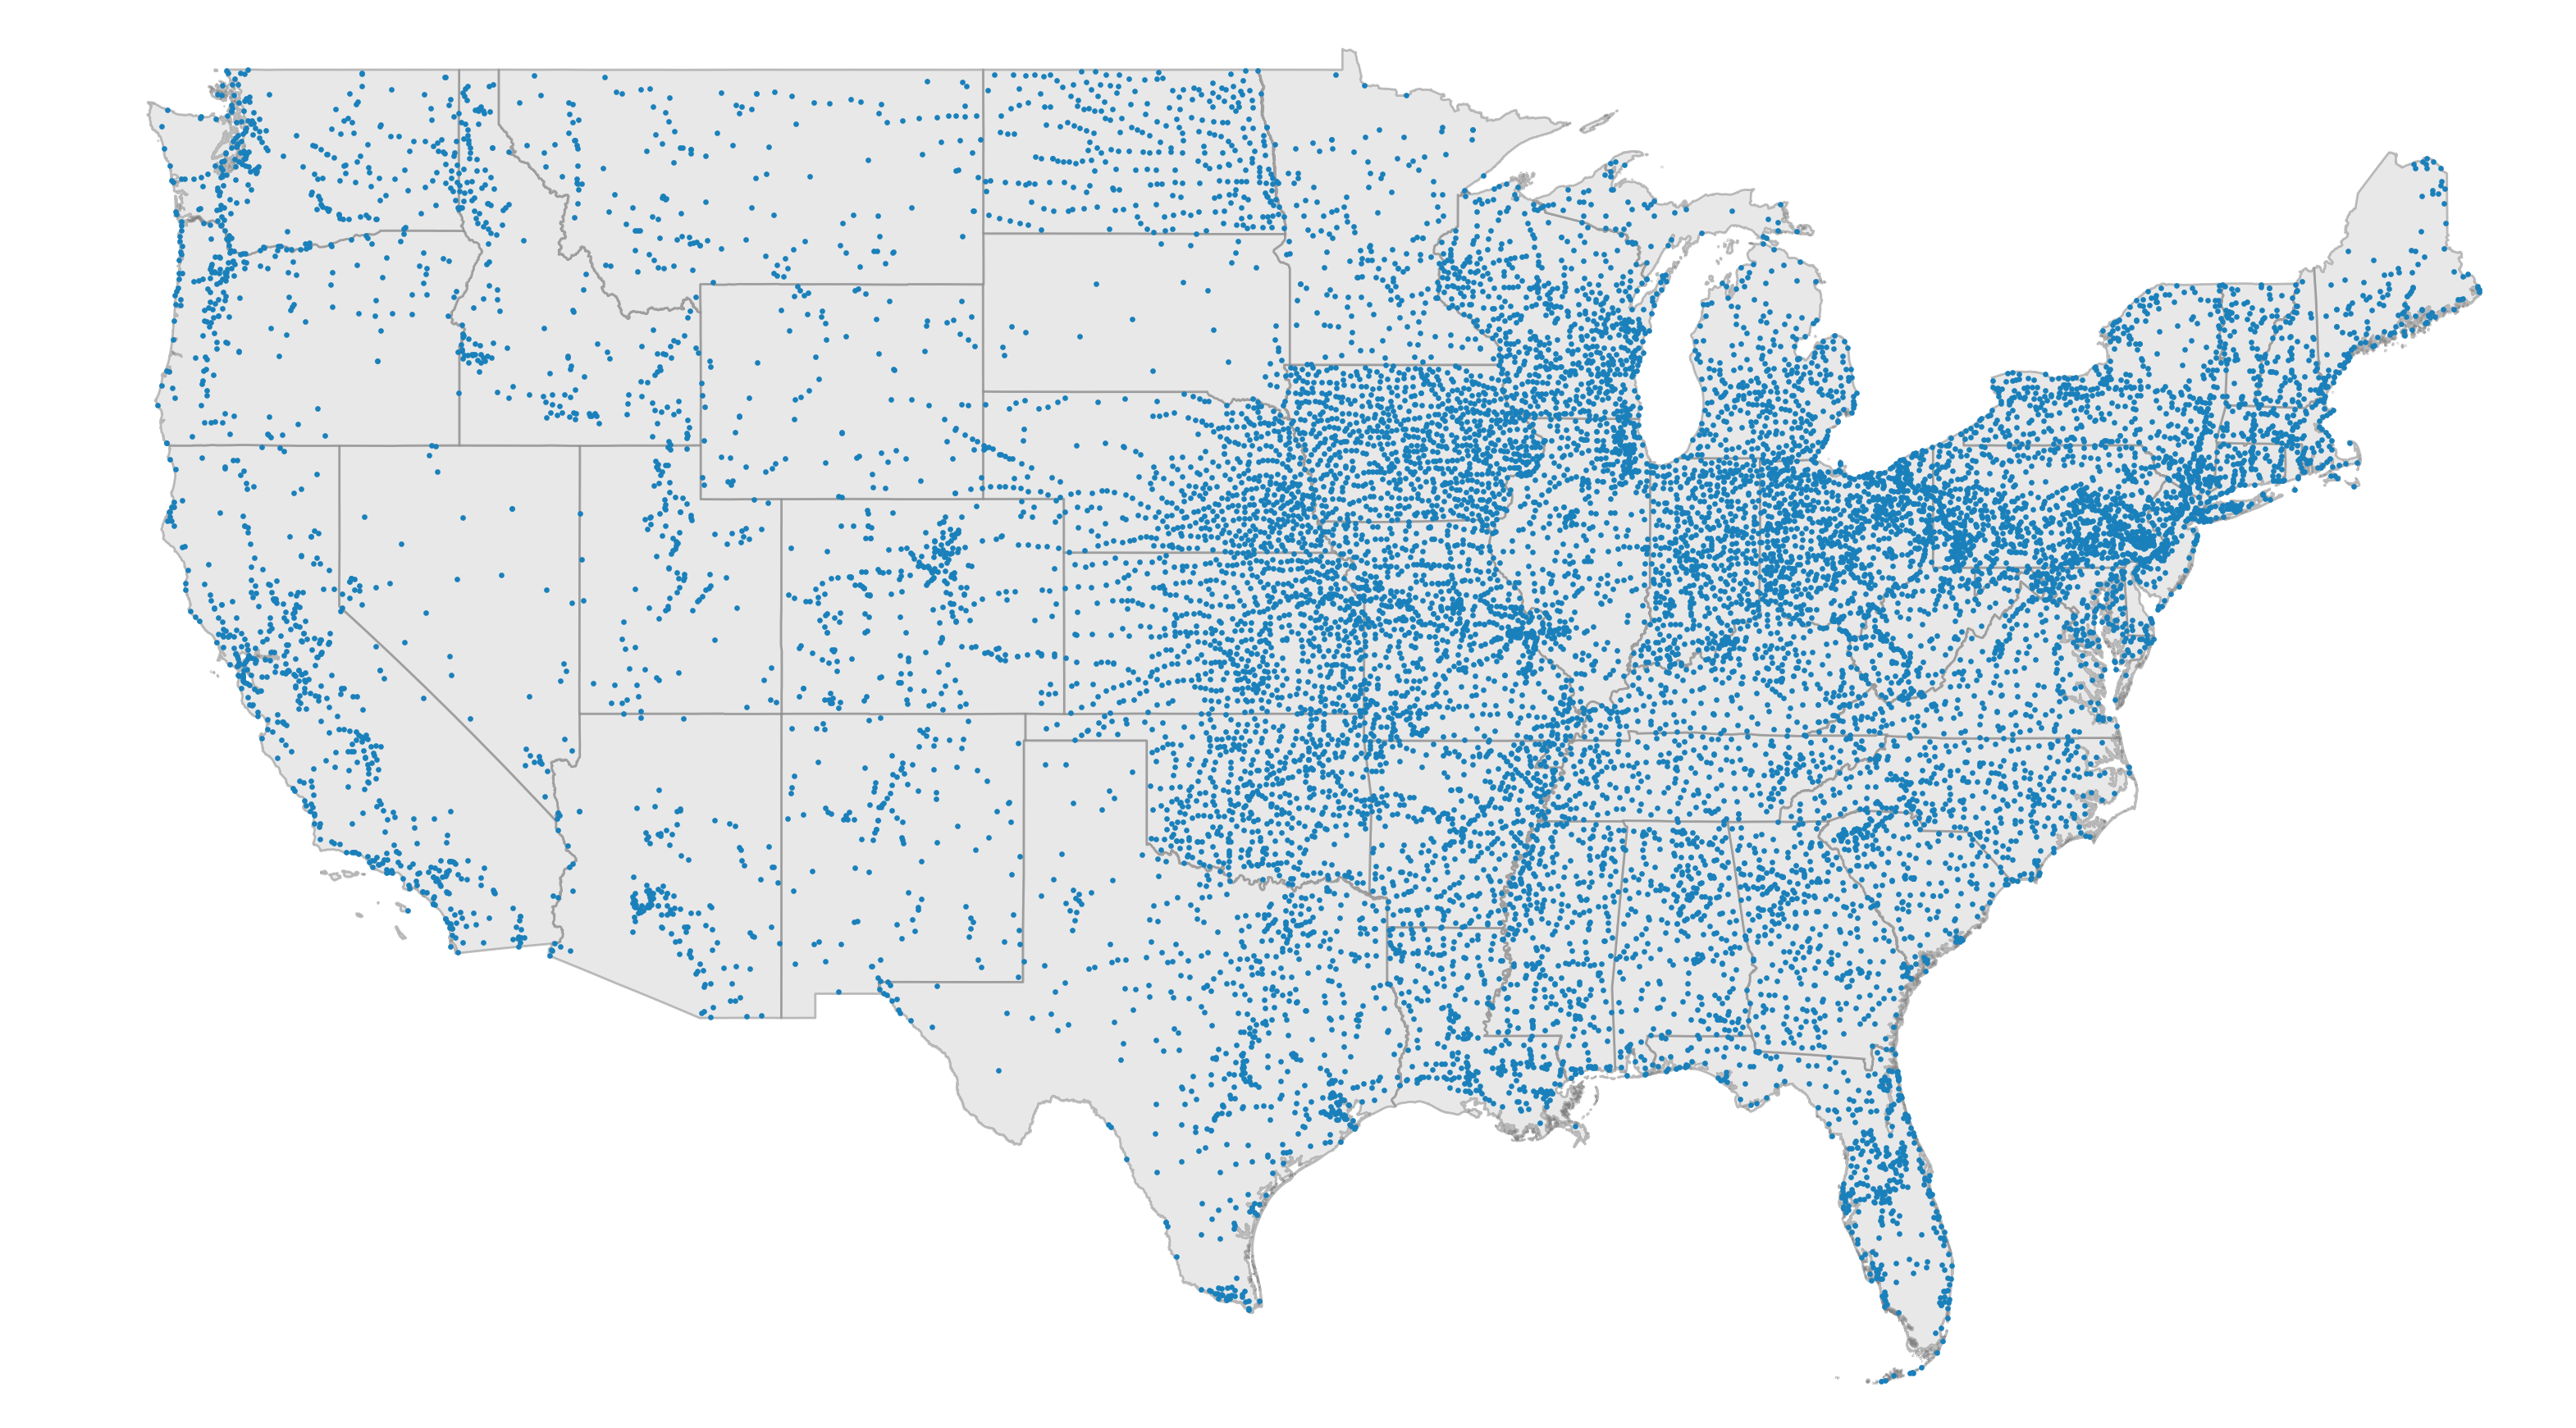

In [19]:
# plot the points and the boundary
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
us_boundary.plot(ax=ax, color="lightgrey", alpha=0.5, edgecolor="grey")
gdf_hw_us.plot(ax=ax, color=blue_color, markersize=2)
# set x and y axis limits
ax.set_xlim(-128, -65)
ax.set_ylim(24, 50)
# plt.title("WWTP in the US from HydroWASTE")
plt.axis("off")
plt.show()

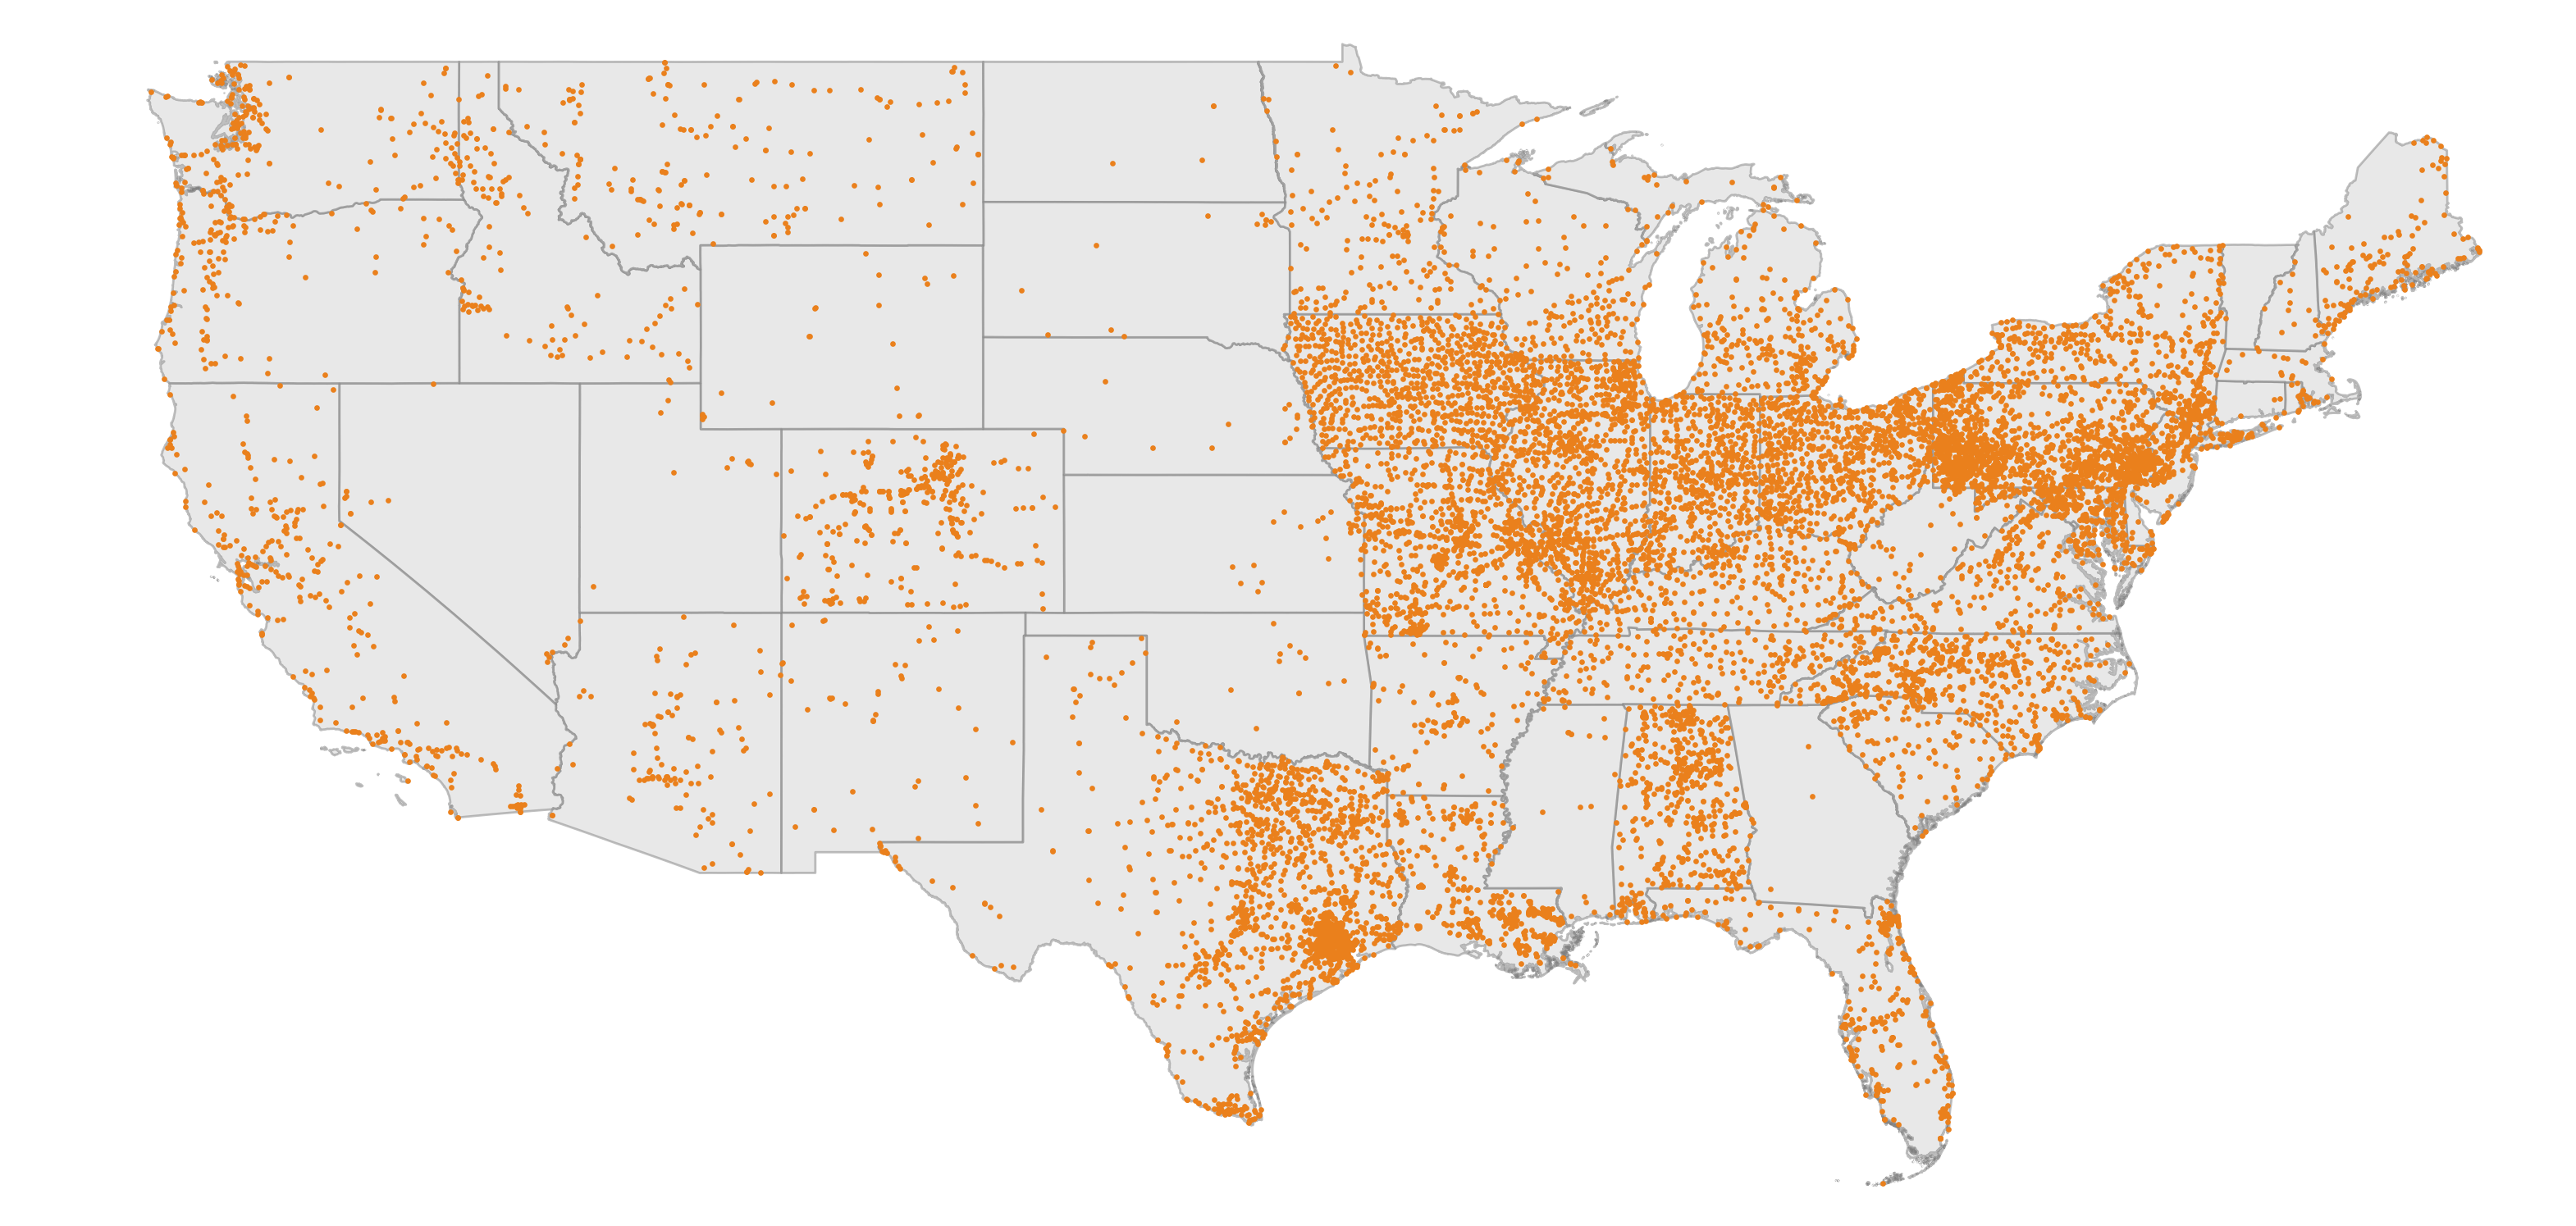

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
us_boundary.plot(ax=ax, color="lightgrey", alpha=0.5, edgecolor="grey")
epa_WWTP.plot(ax=ax, color=orange_color, markersize=2)
# set x and y axis limits
ax.set_xlim(-128, -65)
ax.set_ylim(24, 50)
# plt.title("WWTP in the US from EPA")
plt.axis("off")
plt.show()

## Compare the number of WWTPs

In [24]:
# state full name and abbreviation
state_pair = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    # "Porto Rico": "PR",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    # "District of Columbia": "DC"
}

In [25]:
WWTP_num = pd.DataFrame()
for state_, state in state_pair.items():
    hw_num = len(df_hw_us[df_hw_us["state"] == state_])
    epa_num = len(epa_WWTP[epa_WWTP["CWP_STATE"] == state])
    WWTP_num = pd.concat(
        [
            WWTP_num,
            pd.DataFrame({"state": [state], "hw_num": [hw_num], "epa_num": [epa_num]}),
        ]
    )
WWTP_num.reset_index(drop=True, inplace=True)
WWTP_num

,state,hw_num,epa_num
0,AL,283,541
1,AK,11,78
2,AZ,140,104
3,AR,370,124
4,CA,482,260
5,CO,266,324
6,CT,89,5
7,DE,12,9
8,FL,363,293
9,GA,329,6


In [31]:
# WWTP_num.to_csv("WWTP_num.csv", index=False)

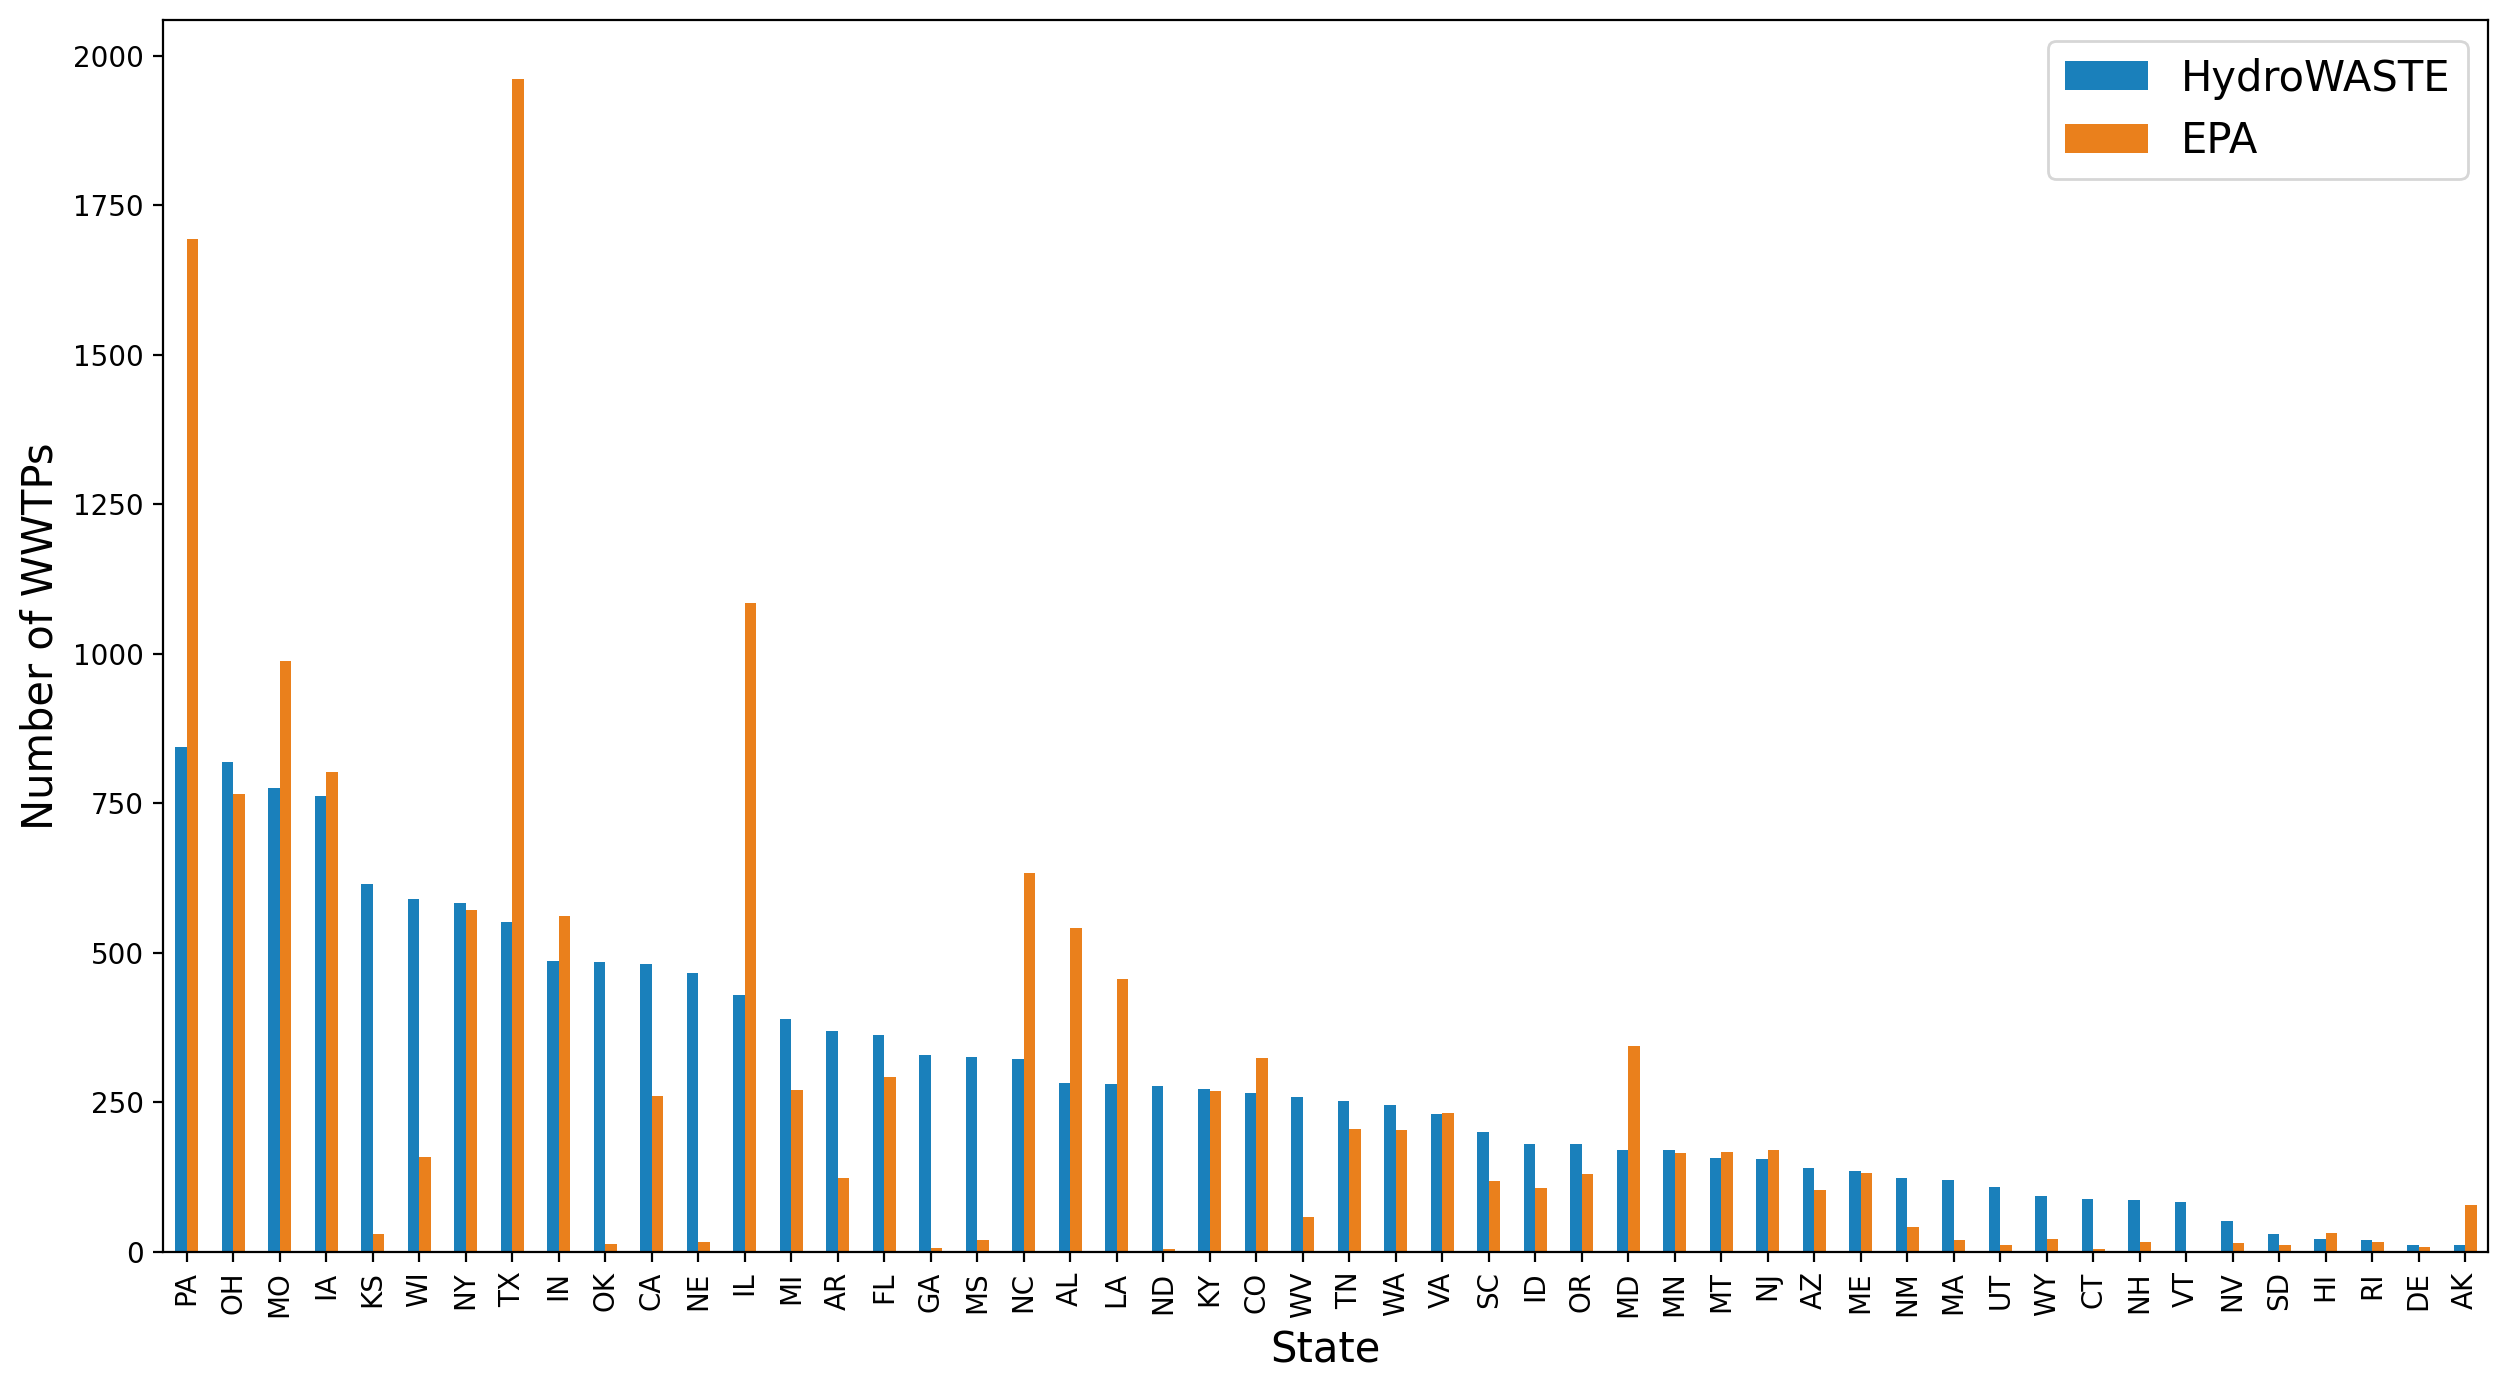

In [30]:
# plot num_HW_WWTPs	and num_EPA_WWTPs side by side, no stacking
sorted_wwtp_num = WWTP_num.sort_values(by="hw_num", ascending=False)
sorted_wwtp_num.plot(
    x="state",
    y=["hw_num", "epa_num"],
    kind="bar",
    figsize=(15, 8),
    color=[blue_color, orange_color],
)
# set legend
plt.legend(["HydroWASTE", "EPA"], fontsize=15)
plt.xlabel("State", fontsize=15)
plt.ylabel("Number of WWTPs", fontsize=15)
plt.show()

In [13]:
print("Number of WWTPs in the US from HydroWASTE: ", len(df_hw_us))
print("Number of WWTPs in the US from EPA: ", len(epa_WWTP))
print(
    "Number of state where EPA has more WWTPs: ",
    len(WWTP_num[WWTP_num["hw_num"] < WWTP_num["epa_num"]]),
)
print(
    "Number of state where HydroWASTE has more WWTPs: ",
    len(WWTP_num[WWTP_num["hw_num"] > WWTP_num["epa_num"]]),
)
print(
    "State where HydroWASTE has more WWTPs: ",
    WWTP_num[WWTP_num["hw_num"] > WWTP_num["epa_num"]]["state"].values,
)

Number of WWTPs in the US from HydroWASTE:  14748
Number of WWTPs in the US from EPA:  14327
Number of state where EPA has more WWTPs:  16
Number of state where HydroWASTE has more WWTPs:  34
State where HydroWASTE has more WWTPs:  ['AZ' 'AR' 'CA' 'CT' 'DE' 'FL' 'GA' 'ID' 'KS' 'KY' 'ME' 'MA' 'MI' 'MN'
 'MS' 'NE' 'NV' 'NH' 'NM' 'NY' 'ND' 'OH' 'OK' 'OR' 'RI' 'SC' 'SD' 'TN'
 'UT' 'VT' 'WA' 'WV' 'WI' 'WY']


## calculate distance -- reference dataset: HW

In [33]:
def statewise_closest_points(state_name, epa, hw):
    hw_state = state_name
    epa_state = state_pair[state_name]

    hw_subset = hw[hw["state"] == hw_state]
    hw_subset.reset_index(drop=True, inplace=True)
    print(f"Number of HW WWTPs in {hw_state}: {hw_subset.shape[0]}")
    epa_subset = epa[epa["CWP_STATE"] == epa_state]
    epa_subset.reset_index(drop=True, inplace=True)
    print(f"Number of EPA WWTPs in {epa_state}: {epa_subset.shape[0]}")

    def closest_point(point, points):
        """Find closest point from a list of points."""
        return points[cKDTree(points).query(point)[1]]

    # Create a list of points
    epa_points = list(zip(epa_subset["epa_lon"], epa_subset["epa_lat"]))
    hw_points = list(zip(hw_subset["hw_lon"], hw_subset["hw_lat"]))

    # Find the closest point for epa points
    closest_epa_points = [closest_point(p, epa_points) for p in hw_points]

    # add to hw df
    hw_subset["epa_lon"], hw_subset["epa_lat"] = zip(*closest_epa_points)
    # add the epa name to hw df
    hw_subset["epa_name"] = epa_subset.loc[
        [cKDTree(epa_points).query(p)[1] for p in hw_points], "CWP_NAME"
    ].values

    # calculate the distance between osm and hw points
    def calculate_distance(row):
        hw_points = (row["hw_lat"], row["hw_lon"])
        epa_point = (row["epa_lat"], row["epa_lon"])
        return geodesic(hw_points, epa_point).kilometers

    hw_subset["distance"] = hw_subset.apply(calculate_distance, axis=1)
    hw_subset.sort_values(by="distance", ascending=True, inplace=True)
    hw_subset.reset_index(drop=True, inplace=True)
    print(
        f"Out of {hw_subset.shape[0]} HW WWTPs, {hw_subset[hw_subset['distance'] < 1].shape[0]} are within 1 km of its closest EPA WWTP."
    )
    print("-" * 50)

    num_summary = [
        len(hw_subset),
        len(epa_subset),
        hw_subset[hw_subset["distance"] < 1].shape[0],
    ]
    return hw_subset, num_summary

In [34]:
# loop through each state, concatenate the results
hw_epa_distance = pd.DataFrame()
hw_epa_statewise_summary = pd.DataFrame()
# number of HW WWTPs in each state, number of EPA WWTPs in each state, number of EPA WWTPs within 1 km of its closest HW WWTP
for idx, state in enumerate(state_pair.keys()):
    df_hw_epa_distance, num_summary = statewise_closest_points(
        state, epa_WWTP, df_hw_us
    )
    hw_epa_distance = pd.concat([hw_epa_distance, df_hw_epa_distance])
    hw_epa_statewise_summary.loc[idx, "state"] = state_pair[state]
    hw_epa_statewise_summary.loc[idx, "num_HW_WWTPs"] = num_summary[0]
    hw_epa_statewise_summary.loc[idx, "num_EPA_WWTPs"] = num_summary[1]
    hw_epa_statewise_summary.loc[idx, "num_HW_WWTPs_within_1km"] = num_summary[2]

Number of HW WWTPs in Alabama: 283
Number of EPA WWTPs in AL: 541
Out of 283 HW WWTPs, 164 are within 1 km of its closest EPA WWTP.
--------------------------------------------------
Number of HW WWTPs in Alaska: 11
Number of EPA WWTPs in AK: 78
Out of 11 HW WWTPs, 2 are within 1 km of its closest EPA WWTP.
--------------------------------------------------
Number of HW WWTPs in Arizona: 140
Number of EPA WWTPs in AZ: 104
Out of 140 HW WWTPs, 35 are within 1 km of its closest EPA WWTP.
--------------------------------------------------
Number of HW WWTPs in Arkansas: 370
Number of EPA WWTPs in AR: 124
Out of 370 HW WWTPs, 76 are within 1 km of its closest EPA WWTP.
--------------------------------------------------
Number of HW WWTPs in California: 482
Number of EPA WWTPs in CA: 260
Out of 482 HW WWTPs, 159 are within 1 km of its closest EPA WWTP.
--------------------------------------------------
Number of HW WWTPs in Colorado: 266
Number of EPA WWTPs in CO: 324
Out of 266 HW WWTPs, 1

In [35]:
hw_epa_distance

,hw_WWTP_NAME,hw_lat,hw_lon,state,epa_lon,epa_lat,epa_name,distance
0,CARBON HILL WWTP,33.883,-87.510,Alabama,-87.509900,33.883000,CARBON HILL WWTP,0.009251
1,FAYETTE WWTP,33.672,-87.820,Alabama,-87.820100,33.672000,FAYETTE WWTP,0.009274
2,ALEXANDER CITY COLEY CREEK WWTP,32.930,-85.882,Alabama,-85.882028,32.929917,ALEXANDER CITY COLEY CREEK WWTP,0.009570
3,FLORALA_LOCKHART WWTP,31.011,-86.350,Alabama,-86.350000,31.011100,LOCKHART FLORALA WWTP,0.011087
4,EUFAULA WWTP,31.853,-85.140,Alabama,-85.140000,31.853100,EUFAULA WWTP,0.011088
...,...,...,...,...,...,...,...,...
89,ALPINE WWTP,43.163,-111.033,Wyoming,-110.534040,41.798390,KEMMERER/DIAMONDVILLE WWTP,157.037419
90,MANVILLE LAGOON,42.764,-104.598,Wyoming,-104.788599,44.337839,PINE HAVEN WWTP,175.535850
91,LUSK LAGOON,42.746,-104.431,Wyoming,-104.788599,44.337839,PINE HAVEN WWTP,179.203922
92,JACKSON LAGOON,43.469,-110.803,Wyoming,-110.534040,41.798390,KEMMERER/DIAMONDVILLE WWTP,186.887070


In [36]:
hw_epa_statewise_summary.loc[:, "percentage_WWTPs_within_1km_with_respect_to_HW"] = (
    round(
        (
            hw_epa_statewise_summary["num_HW_WWTPs_within_1km"]
            / hw_epa_statewise_summary["num_HW_WWTPs"]
        )
        * 100,
        2,
    )
)
hw_epa_statewise_summary.sort_values(
    by="percentage_WWTPs_within_1km_with_respect_to_HW", ascending=False
)

,state,num_HW_WWTPs,num_EPA_WWTPs,num_HW_WWTPs_within_1km,percentage_WWTPs_within_1km_with_respect_to_HW
18,ME,135.0,132.0,115.0,85.19
14,IA,763.0,802.0,634.0,83.09
12,IL,429.0,1085.0,338.0,78.79
19,MD,171.0,344.0,134.0,78.36
16,KY,272.0,269.0,203.0,74.63
32,NC,323.0,634.0,234.0,72.45
13,IN,486.0,562.0,349.0,71.81
38,RI,20.0,16.0,14.0,70.00
34,OH,819.0,766.0,566.0,69.11
31,NY,583.0,571.0,396.0,67.92


In [37]:
print(
    f"Number of WWTPs in HydroWASTE that has a corresponding WWTP (<1km) in EPA: {hw_epa_distance.loc[hw_epa_distance['distance'] < 1].shape[0]}"
)
print(f"Number of WWTPs in HydroWASTE : {len(df_hw_us)}")
print(
    f"Percentage of WWTPs in HydroWASTE that has a corresponding WWTP (<1km) in EPA: {round((hw_epa_distance.loc[hw_epa_distance['distance'] < 1].shape[0] / len(df_hw_us)) * 100, 2)}%"
)

Number of WWTPs in HydroWASTE that has a corresponding WWTP (<1km) in EPA: 6427
Number of WWTPs in HydroWASTE : 14748
Percentage of WWTPs in HydroWASTE that has a corresponding WWTP (<1km) in EPA: 43.58%


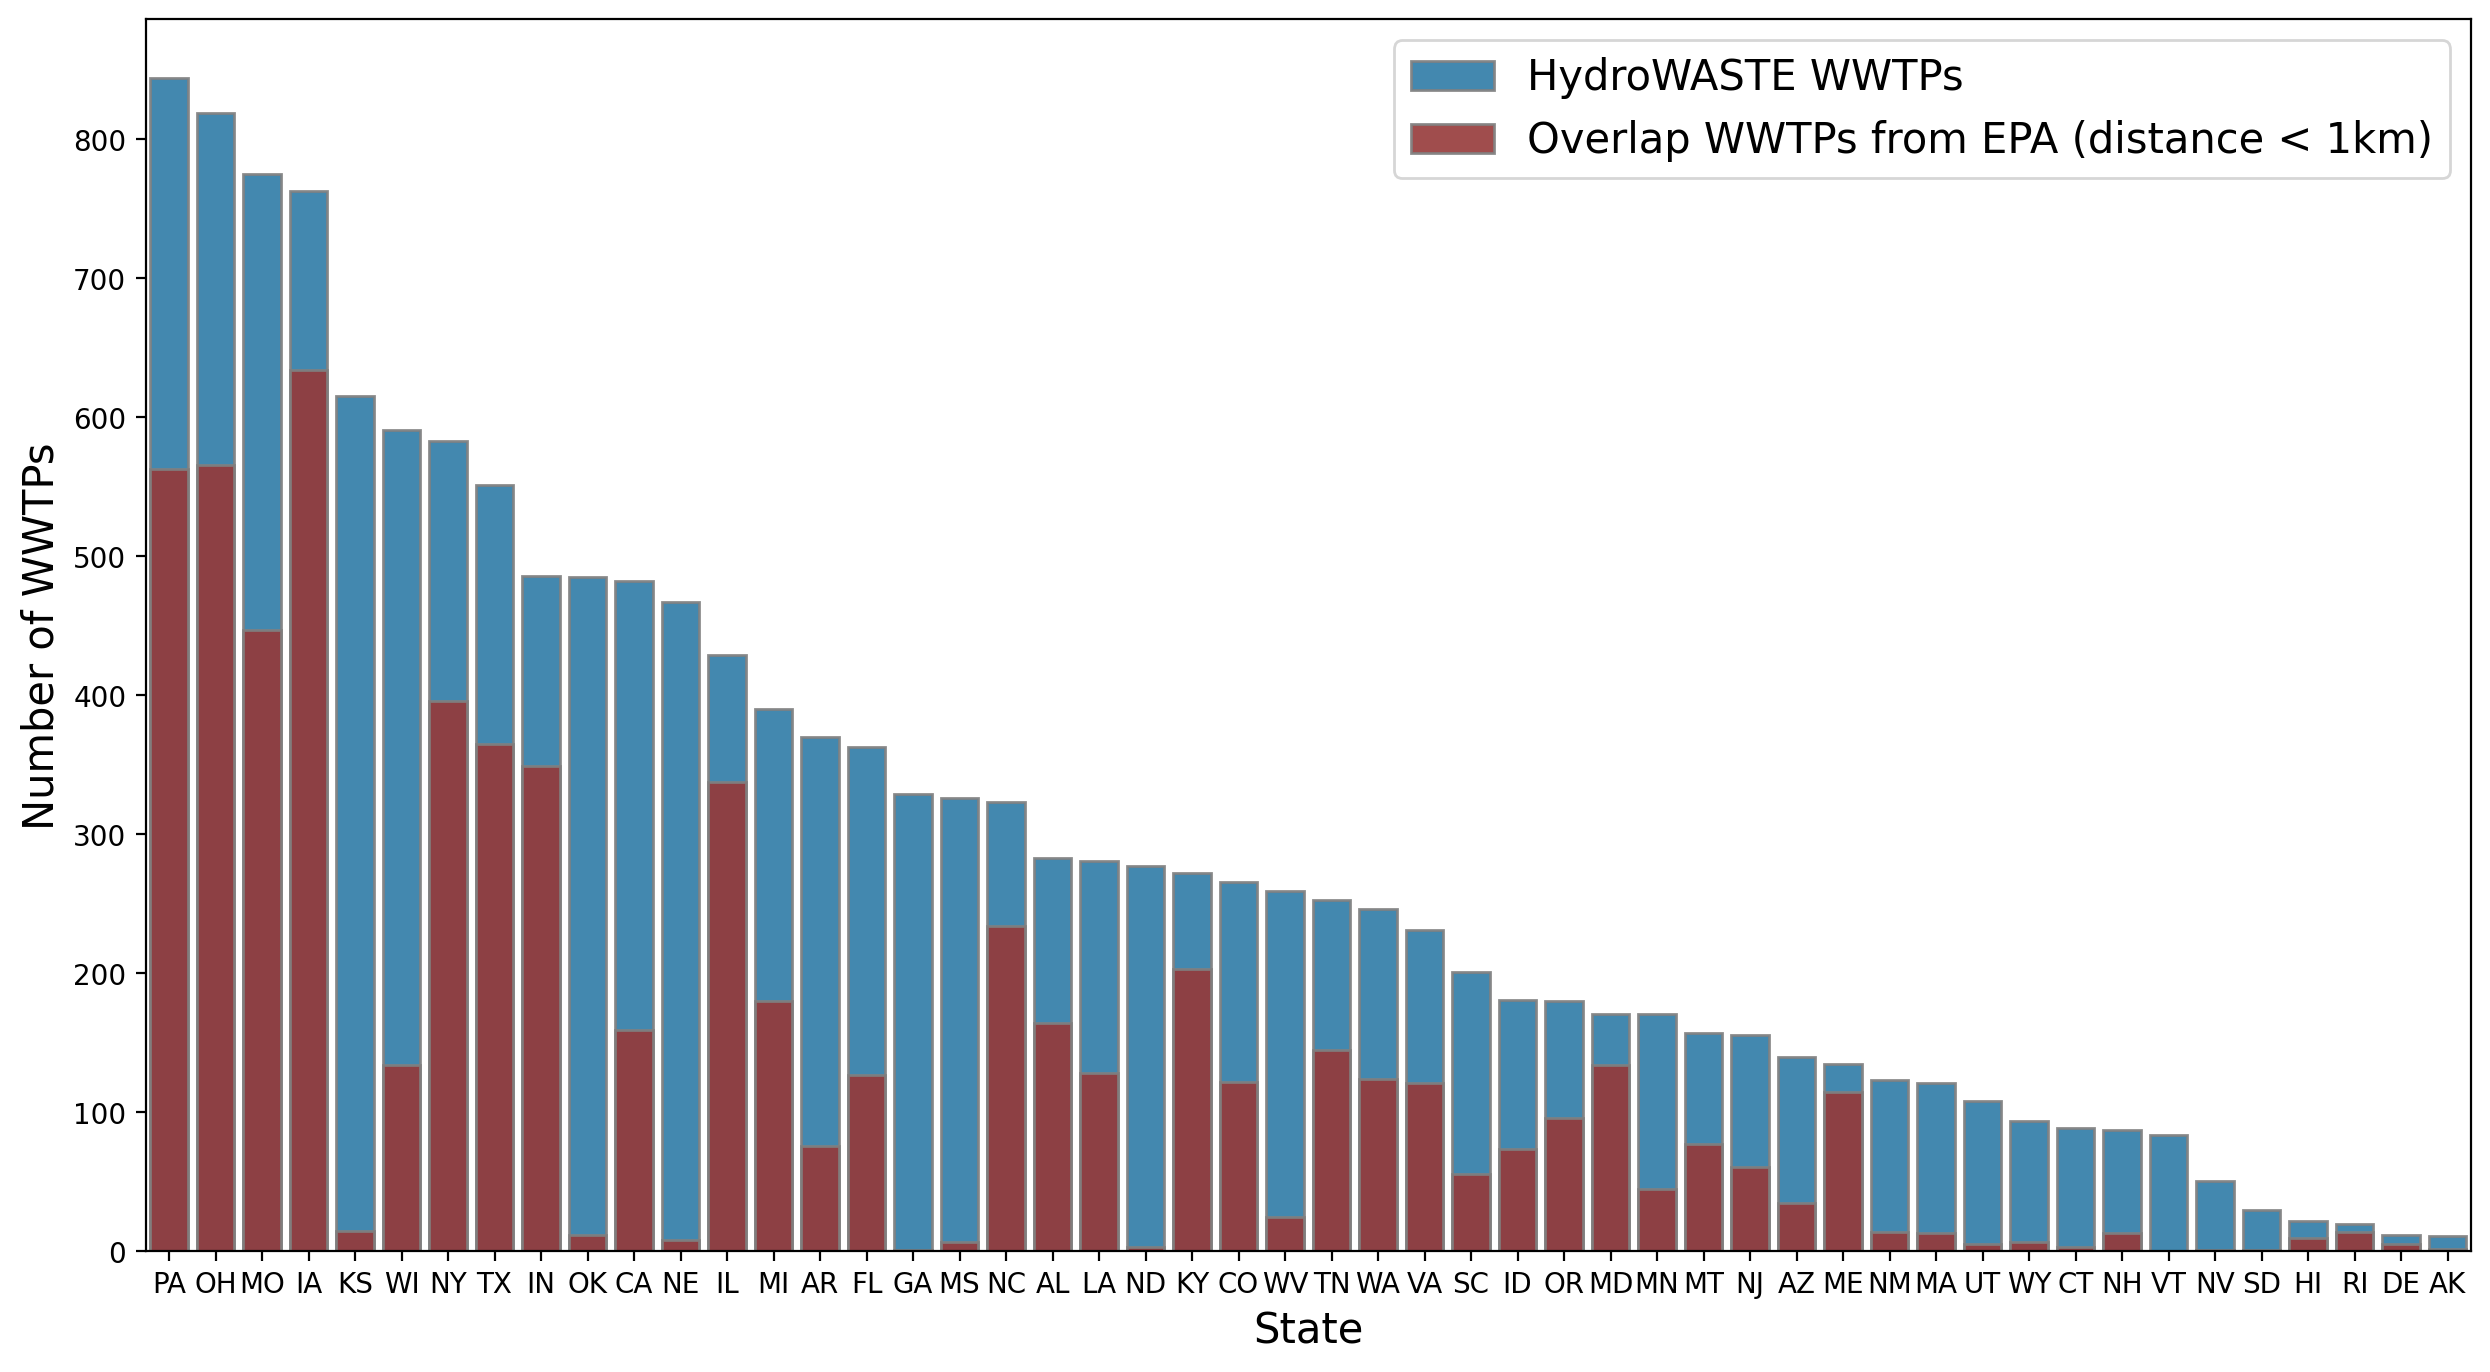

In [45]:
# plot a stack bar chart, x-axis: states, y-axis: num_EPA_WWTPs, num_EPA_WWTPs_within_1km,
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 8))
sorted_hw_epa_statewise_summary = hw_epa_statewise_summary.sort_values(
    by="num_HW_WWTPs", ascending=False
)
sns.barplot(
    x="state",
    y="num_HW_WWTPs",
    data=sorted_hw_epa_statewise_summary,
    color=blue_color,
    alpha=0.9,
    label="HydroWASTE WWTPs",
    edgecolor="grey",
)
sns.barplot(
    x="state",
    y="num_HW_WWTPs_within_1km",
    data=sorted_hw_epa_statewise_summary,
    color="brown",
    alpha=0.9,
    label="Overlap WWTPs from EPA (distance < 1km)",
    edgecolor="grey",
)
plt.xlabel("State", fontsize=15)
plt.ylabel("Number of WWTPs", fontsize=15)
plt.legend(fontsize=15)
plt.show()

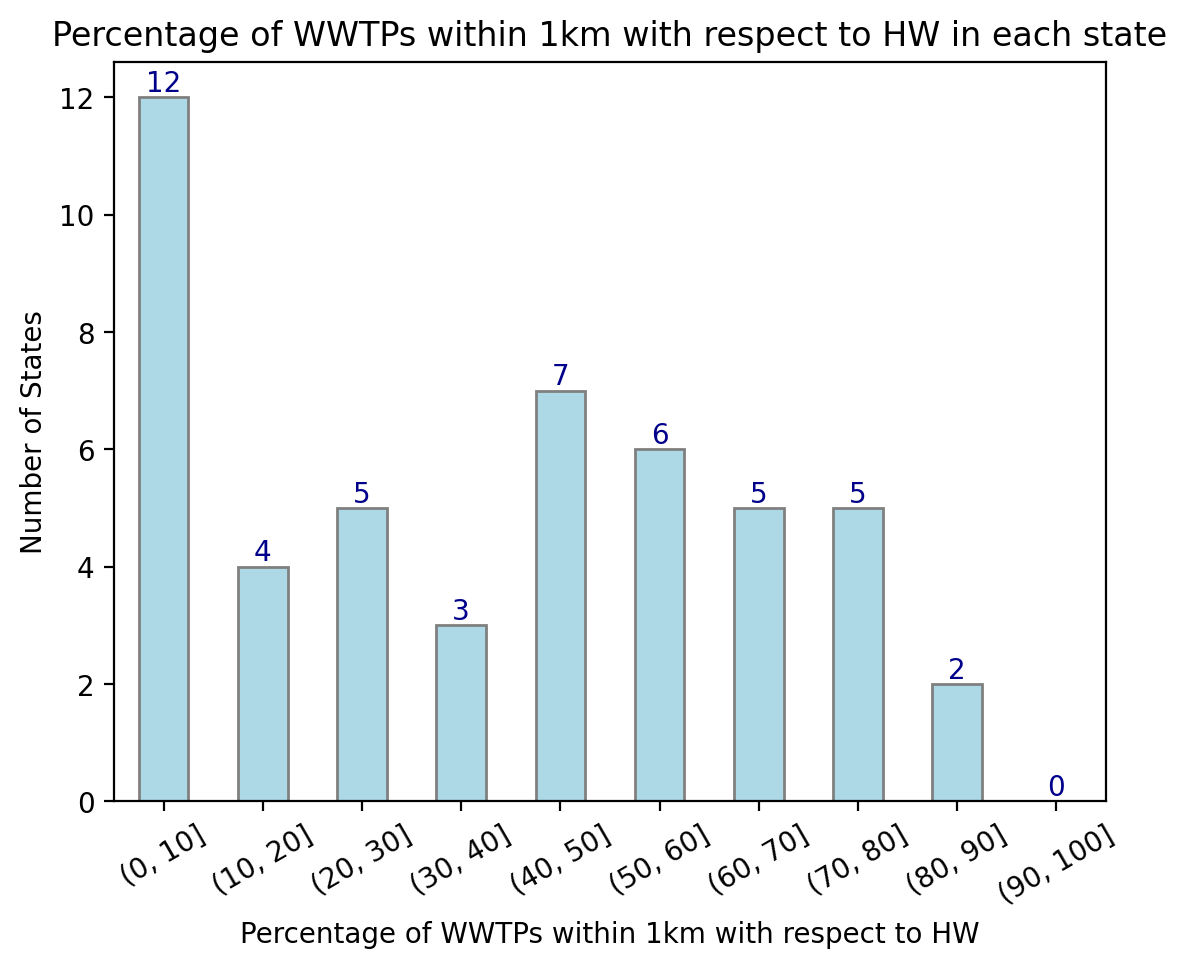

In [28]:
# put percentage_WWTPs_within_1km_with_respect_to_EPA into several bines, and plot a barplot of the number of states in each bin
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
hw_epa_statewise_summary["percentage_bins"] = pd.cut(
    hw_epa_statewise_summary["percentage_WWTPs_within_1km_with_respect_to_HW"], bins
)
hw_epa_statewise_summary["percentage_bins"].value_counts().sort_index().plot(
    kind="bar", color="lightblue", edgecolor="grey"
)
plt.xlabel("Percentage of WWTPs within 1km with respect to HW")
plt.ylabel("Number of States")
plt.xticks(rotation=30)
# put numbers on top of the bars
for i in range(
    len(hw_epa_statewise_summary["percentage_bins"].value_counts().sort_index())
):
    plt.text(
        i,
        hw_epa_statewise_summary["percentage_bins"]
        .value_counts()
        .sort_index()
        .values[i],
        hw_epa_statewise_summary["percentage_bins"]
        .value_counts()
        .sort_index()
        .values[i],
        ha="center",
        va="bottom",
        color="darkblue",
    )
plt.title("Percentage of WWTPs within 1km with respect to HW in each state")
plt.show()

In [ ]:
selected_states = [
    "AZ"
    "AR"
    "CA"
    "CT"
    "DE"
    "FL"
    "GA"
    "ID"
    "KS"
    "KY"
    "ME"
    "MA"
    "MI"
    "MN"
    "MS"
    "NE"
    "NV"
    "NH"
    "NM"
    "NY"
    "ND"
    "OH"
    "OK"
    "OR"
    "RI"
    "SC"
    "SD"
    "TN"
    "UT"
    "VT"
    "WA"
    "WV"
    "WI"
    "WY"
]

# plot a us map with the above states highlighted
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
us

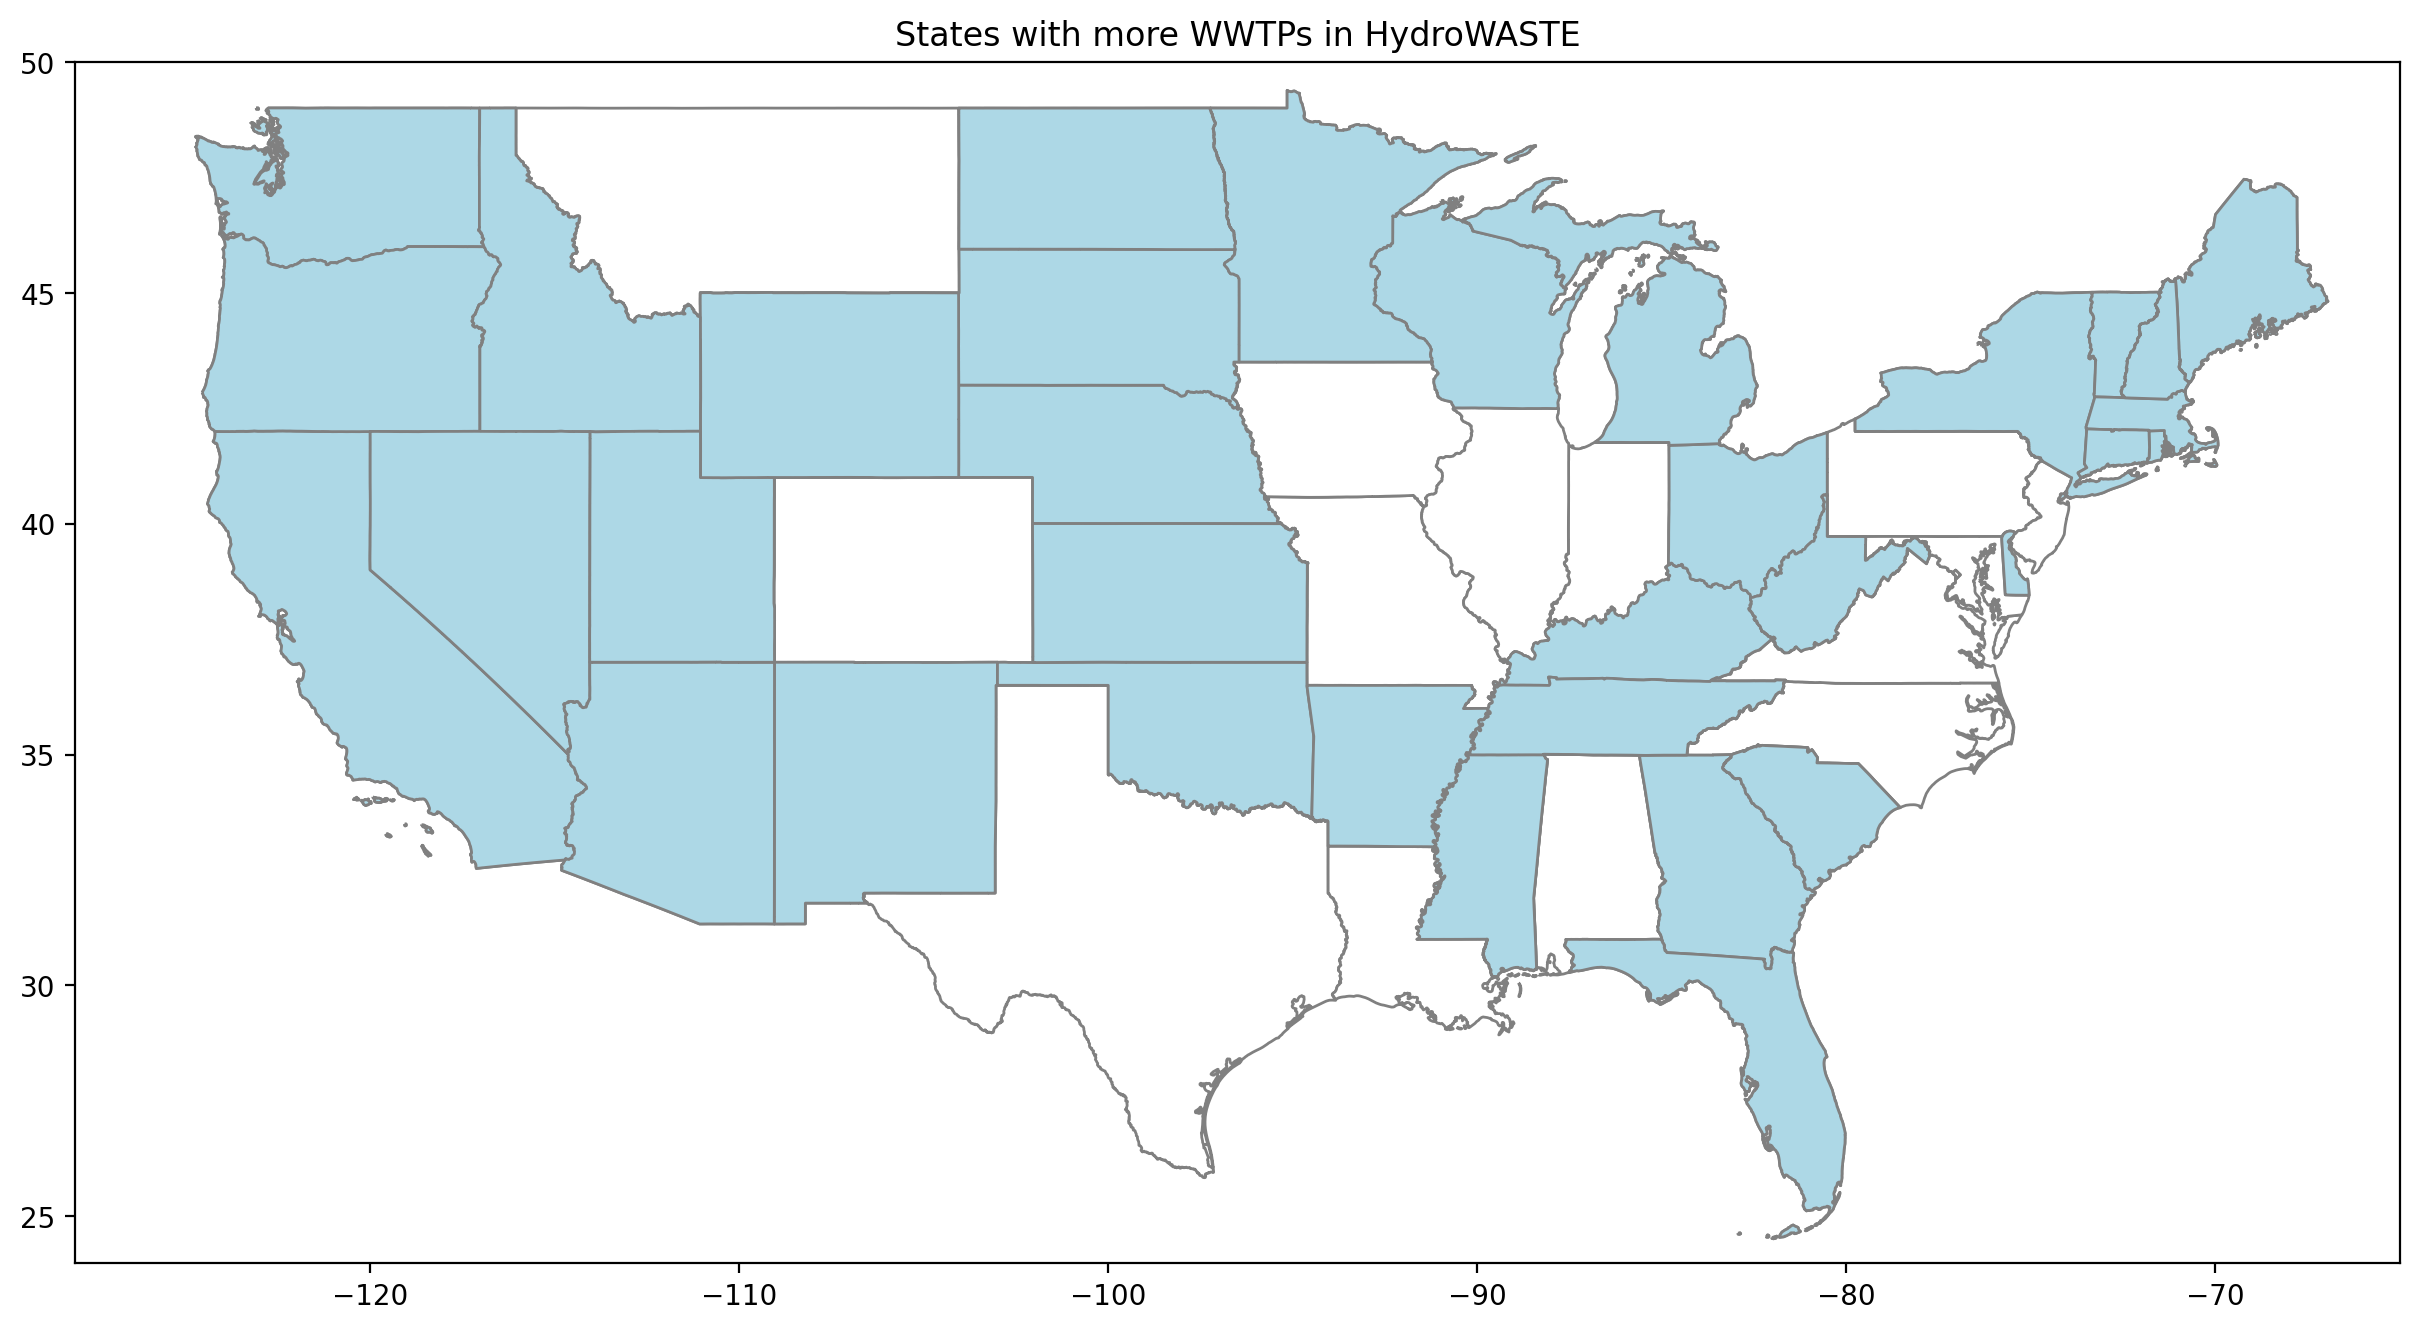

In [51]:
import geopandas as gpd
import matplotlib.pyplot as plt

# List of selected states
selected_states = [
    "AZ",
    "AR",
    "CA",
    "CT",
    "DE",
    "FL",
    "GA",
    "ID",
    "KS",
    "KY",
    "ME",
    "MA",
    "MI",
    "MN",
    "MS",
    "NE",
    "NV",
    "NH",
    "NM",
    "NY",
    "ND",
    "OH",
    "OK",
    "OR",
    "RI",
    "SC",
    "SD",
    "TN",
    "UT",
    "VT",
    "WA",
    "WV",
    "WI",
    "WY",
]

# Filter for the United States
us_states = gpd.read_file("cb_2018_us_state_5m")
us_states = us_states.to_crs(epsg=4326)

# Highlight the selected states
us_states["highlight"] = us_states["STUSPS"].apply(lambda x: x in selected_states)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
base = us_states.plot(ax=ax, color="white", edgecolor="grey")
us_states[us_states["highlight"]].plot(ax=base, color="lightblue", edgecolor="grey")
ax.set_xlim(-128, -65)
ax.set_ylim(24, 50)
# set
plt.title("States with more WWTPs in HydroWASTE")
plt.show()